In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import joblib
import random

# === Paths ===
base_dir = "/Users/gemwincanete/Thesis /datasets/mfccfeatures"
metadata_path = os.path.join(base_dir, "metadata.csv")

# === Load metadata ===
df = pd.read_csv(metadata_path)
print(df.head())

# === Classes from metadata ===
class_names = sorted(df['label'].unique())
print("Classes:", class_names)

X_train, y_train_labels = [], []
X_test, y_test_labels = [], []

# === Iterate rows using metadata ===
for _, row in df.iterrows():
    filename = row['filename']
    label = row['label']
    split = row['split']  # "train" or "test"

    # NOTE: folder structure is /<label>/<split>/<filename>.npy
    filepath = os.path.join(base_dir, label, split, filename)

    if not os.path.exists(filepath):
        print("Missing file:", filepath)
        continue

    mfcc = np.load(filepath)

    if split == "train":
        X_train.append(mfcc)
        y_train_labels.append(label)
    elif split == "test":
        X_test.append(mfcc)
        y_test_labels.append(label)

print(f"Loaded {len(X_train)} train and {len(X_test)} test samples.")

# === Encode labels ===
le = LabelEncoder()
integer_labels_train = le.fit_transform(y_train_labels)
integer_labels_test = le.transform(y_test_labels)

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping:", label_mapping)

# === One-hot encode ===
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(integer_labels_train.reshape(-1, 1))
y_test = ohe.transform(integer_labels_test.reshape(-1, 1))

# === Pad sequences to max train length ===
max_timesteps_train = max(mfcc.shape[1] for mfcc in X_train)
X_train = np.array([
    np.pad(mfcc, ((0, 0), (0, max_timesteps_train - mfcc.shape[1])), mode='constant')
    for mfcc in X_train
])
X_test = np.array([
    np.pad(mfcc, ((0, 0), (0, max_timesteps_train - mfcc.shape[1])), mode='constant')
    for mfcc in X_test
])

# === Fit scaler ===
all_train_frames = np.hstack(X_train)  # shape: (features, total_timesteps)
scaler = StandardScaler().fit(all_train_frames.T)

# Save scaler
scaler_dir = "/Users/gemwincanete/Thesis /models/scaler"
os.makedirs(scaler_dir, exist_ok=True)
joblib.dump(scaler, os.path.join(scaler_dir, "scaler.pkl"))

# Apply scaling
X_train_scaled = np.array([scaler.transform(mfcc.T).T for mfcc in X_train])
X_test_scaled = np.array([scaler.transform(mfcc.T).T for mfcc in X_test])

# === Final sanity checks ===
print("Train set:", X_train_scaled.shape, y_train.shape)
print("Test set:", X_test_scaled.shape, y_test.shape)

# Preview random samples
rand_idx = random.sample(range(len(X_train_scaled)), min(5, len(X_train_scaled)))
for i in rand_idx:
    print(f"Sample index {i}")
    print("MFCC shape:", X_train_scaled[i].shape)
    print("Label (one-hot):", y_train[i])
    print()


                   filename          label split
0   184_1308073010307_A.npy  extra_systole  test
1   275_1310990852160_B.npy  extra_systole  test
2   140_1306519735121_D.npy  extra_systole  test
3   213_1308245263936_D.npy  extra_systole  test
4  134_1306428161797_C1.npy  extra_systole  test
Classes: ['artifact', 'extra_heart_audio', 'extra_systole', 'murmur', 'normal']
Loaded 1280 train and 118 test samples.
Label mapping: {np.str_('artifact'): 0, np.str_('extra_heart_audio'): 1, np.str_('extra_systole'): 2, np.str_('murmur'): 3, np.str_('normal'): 4}
Train set: (1280, 39, 196) (1280, 5)
Test set: (118, 39, 196) (118, 5)
Sample index 843
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 0. 0. 1.]

Sample index 315
MFCC shape: (39, 196)
Label (one-hot): [0. 1. 0. 0. 0.]

Sample index 1255
MFCC shape: (39, 196)
Label (one-hot): [1. 0. 0. 0. 0.]

Sample index 441
MFCC shape: (39, 196)
Label (one-hot): [0. 1. 0. 0. 0.]

Sample index 1082
MFCC shape: (39, 196)
Label (one-hot): [1. 0. 0. 0. 0.

Model Tensor flow

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

In [3]:
# Reshape to (samples, timesteps, features)
X_train_final = np.array([mfcc.T for mfcc in X_train_scaled])
X_test_final  = np.array([mfcc.T for mfcc in X_test_scaled])

# Get dynamic input shape for LSTM
input_shape = X_train_final[0].shape  # (timesteps, features)
num_classes = y_train.shape[1]

# Build model with dynamic input shape
model = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 196, 128)       │        53,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,949 (386.52 KB)

 Trainable params: 98,949 (386.52 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
input_shape

(196, 39)

In [5]:
history = model.fit(
    X_train_final, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3559 - f1_score: 0.2771 - loss: 1.4001 - precision: 0.4441 - recall: 0.0252 - val_accuracy: 0.0156 - val_f1_score: 0.1600 - val_loss: 3.3853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6593 - f1_score: 0.5205 - loss: 0.8224 - precision: 0.8506 - recall: 0.3772 - val_accuracy: 0.0195 - val_f1_score: 0.1538 - val_loss: 4.4872 - val_precision: 0.0162 - val_recall: 0.0117
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6992 - f1_score: 0.5627 - loss: 0.6700 - precision: 0.7624 - recall: 0.5915 - val_accuracy: 0.0156 - val_f1_score: 0.1600 - val_loss: 4.8750 - val_precision: 0.0192 - val_recall: 0.0156
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7732 - f1_score: 0.6204 - loss: 0.5354 - precision: 0.8061 - recall: 0.7359 - val_accuracy: 0.0156 - val_f1_score: 0.0762 - val_loss: 5.1137 - val_precision: 0.0196 - val

In [6]:
test_loss, test_acc, *metrics = model.evaluate(X_test_final, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5566 - f1_score: 0.3243 - loss: 4.9846 - precision: 0.5566 - recall: 0.5566 
Test accuracy: 0.6102


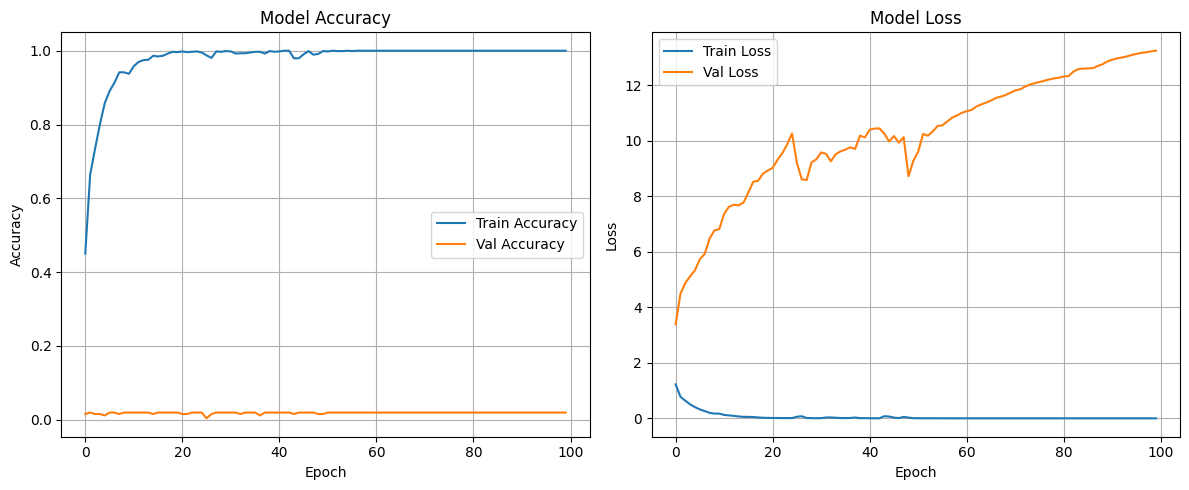

In [7]:
import matplotlib.pyplot as plt

# === Plot training history ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


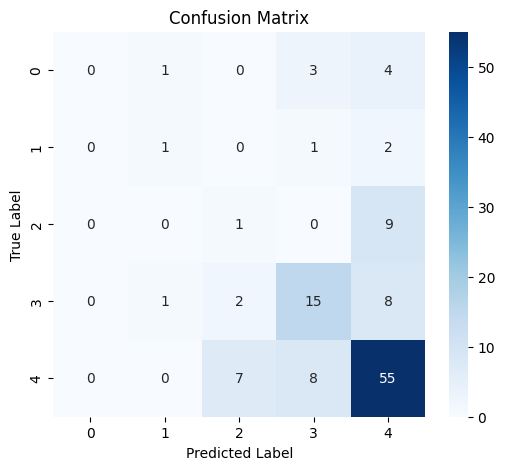

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()